<a href="https://colab.research.google.com/github/VandenHendeCatherine/DataMining/blob/main/VandenHende_Petit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projet de DataMining
Par Catherine Vanden Hende & Yohan Petit

##Initialisation du Projet

In [130]:
!wget -q --show-progress --no-check-certificate 'https://docs.google.com/uc?export=download&id=17ockZAT8Uf8fmgKPKIfKI4s2_bpCtOhd' -O kaggle.json
! pip install kaggle
! rm -r ~/.kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d razinw/dog-vs-cat
! rm -r images
! mkdir images
! unzip dog-vs-cat.zip -d images/

kaggle.json         100%[===================>]      66  --.-KB/s    in 0s      
dog-vs-cat.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  dog-vs-cat.zip
  inflating: images/dogvscat/test/0/250.jpg  
  inflating: images/dogvscat/test/0/251.jpg  
  inflating: images/dogvscat/test/0/252.jpg  
  inflating: images/dogvscat/test/0/253.jpg  
  inflating: images/dogvscat/test/0/254.jpg  
  inflating: images/dogvscat/test/0/255.jpg  
  inflating: images/dogvscat/test/0/256.jpg  
  inflating: images/dogvscat/test/0/257.jpg  
  inflating: images/dogvscat/test/0/258.jpg  
  inflating: images/dogvscat/test/0/259.jpg  
  inflating: images/dogvscat/test/0/260.jpg  
  inflating: images/dogvscat/test/0/261.jpg  
  inflating: images/dogvscat/test/0/262.jpg  
  inflating: images/dogvscat/test/0/263.jpg  
  inflating: images/dogvscat/test/0/264.jpg  
  inflating: images/dogvscat/test/0/265.jpg  
  inflating: images/dogvscat/test/0/266.jpg  
  inflating: im

##Récupération des métadonnées dans des json

In [131]:
!pip3 install Pillow
!mkdir metadata
!mkdir metadata/train
!mkdir metadata/train/0
!mkdir metadata/train/1
!mkdir metadata/test
!mkdir metadata/test/0
!mkdir metadata/test/1

from PIL import Image
from PIL.ExifTags import TAGS
import os
import json

# path to the directory
path0 = "images/dogvscat/train/0"
path1 = "images/dogvscat/train/1"
path2 = "images/dogvscat/test/0"
path3 = "images/dogvscat/test/1"

def exportMetadata(path,start=0):
  # directory
  directory = os.listdir(path)
  metadata = []
  photo = dict()

  for x,files in enumerate(directory):
    if files.endswith ('.jpg'):
      # find file path
      file_path = os.path.join(path,files)
      # read the image data using PIL
      image = Image.open(file_path)
      # extract EXIF data
      exifdata = image.getexif()
      # add id
      photo['id']=x+start
      # iterating over all EXIF data fields
      for tag_id in exifdata:
          # get the tag name, instead of human unreadable tag id
          tag = TAGS.get(tag_id, tag_id)
          data = exifdata.get(tag_id)
          # decode bytes 
          if isinstance(data, bytes):
              data = data.decode()
          if tag != 'GPSInfo':
            photo[tag]=data
      # metadata list for each photo
      metadata.append(photo)
      photo = {}
  return metadata

# create json file
with open("metadata/train/0/metadata.json", "w") as file:
    json.dump(exportMetadata(path0), file, separators=(',', ':'), indent=4)
with open("metadata/train/1/metadata.json", "w") as file:
    json.dump(exportMetadata(path1), file, separators=(',', ':'), indent=4)
with open("metadata/test/0/metadata.json", "w") as file:
    json.dump(exportMetadata(path2,250), file, separators=(',', ':'), indent=4)
with open("metadata/test/1/metadata.json", "w") as file:
    json.dump(exportMetadata(path3,250), file, separators=(',', ':'), indent=4)

mkdir: cannot create directory ‘metadata’: File exists
mkdir: cannot create directory ‘metadata/train’: File exists
mkdir: cannot create directory ‘metadata/train/0’: File exists
mkdir: cannot create directory ‘metadata/train/1’: File exists
mkdir: cannot create directory ‘metadata/test’: File exists
mkdir: cannot create directory ‘metadata/test/0’: File exists
mkdir: cannot create directory ‘metadata/test/1’: File exists


##Étiquetage et annotation

In [132]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
from sklearn.cluster import MiniBatchKMeans
import json

def to_tag(folder,tag,test=False):
  tags=[]
  photo = dict()
  nbImages = 250
  start = 0
  if test :
    nbImages = 25
    start = 250
  for j in range(nbImages):
    imgfile = Image.open(folder+str(j+start)+".jpg")
    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    clusters = MiniBatchKMeans(n_clusters=4)
    clusters.fit(numarray)
    colors=[]
    photo["id"]=str(j+start)
    photo["tag"]=tag
    colors.append('#%02x%02x%02x' % (
      math.ceil(clusters.cluster_centers_[0][0]),
      math.ceil(clusters.cluster_centers_[0][1]),
      math.ceil(clusters.cluster_centers_[0][2]),
      )
    )
    photo["color"]=colors[0]
    tags.append(photo)
    photo = {}
  return tags

with open("metadata/train/0/tag.json", "w") as file:
    json.dump(to_tag("images/dogvscat/train/0/","chat"), file, separators=(',', ':'), indent=4)
with open("metadata/train/1/tag.json", "w") as file:
    json.dump(to_tag("images/dogvscat/train/1/","chien"), file, separators=(',', ':'), indent=4)
with open("metadata/test/0/tag.json", "w") as file:
    json.dump(to_tag("images/dogvscat/test/0/","chat",True), file, separators=(',', ':'), indent=4)
with open("metadata/test/1/tag.json", "w") as file:
    json.dump(to_tag("images/dogvscat/test/1/","chien",True), file, separators=(',', ':'), indent=4)

##Analyses de données

In [133]:
#Création des profiles utilisateurs
def likeUser(liked, tag1, tag2):
  photo=dict()
  likePhoto=[]
  for i in range(250):
    photo["id"]=i
    if i in liked :
      photo["like"]=1
    else : 
      photo["like"]=0
    photo["tag"]=tag1
    likePhoto.append(photo)
    photo={}
  for i in range(250):
    photo["id"]=i
    photo["like"]=0
    photo["tag"]=tag2
    likePhoto.append(photo)
    photo = {}
  return likePhoto

#User1 photo cat with Nikon D5200
user1=[2,8,9,32,37,46,53,57,67,68,89,99,171,173,192,199,209,215,218]
with open("metadata/train/like_user1.json","w") as file:
  json.dump(likeUser(user1, "chat", "chien"), file, separators=(',', ':'), indent=4)
#User2 Chien roux
user2=[0,117,118,122,132,137,14,143,146,147,151,156,166,170,189,2,204,210,211,222,243,248,27,39,45,54,75]
with open("metadata/train/like_user2.json","w") as file:
  json.dump(likeUser(user2, "chien", "chat"), file, separators=(',', ':'), indent=4)
#User3 Chat gris
user3=[1,102,105,11,115,116,119,12,130,132,141,147,149,153,154,166,182,185,19,207,208,212,231,230,23,28,53,58,6,74,85,95]
with open("metadata/train/like_user3.json","w") as file:
  json.dump(likeUser(user3, "chat", "chien"), file, separators=(',', ':'), indent=4)

##Visualisation des données

{'2010': 6, '2015': 61, '2017': 76, '2018': 55, '2013': 41, '2016': 72, '2014': 38, '2005': 3, '2012': 10, '2019': 32, '2011': 6, '2008': 2, '2006': 2, '2009': 6, '2007': 2}


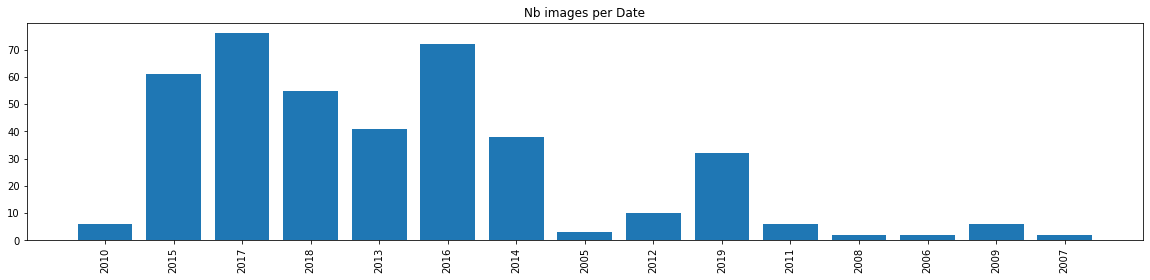

{'Canon EOS 500D': 5, 'NIKON D5200': 24, 'ILCE-6000': 8, 'NIKON D750': 5, 'NIKON D5000': 1, 'SLT-A99V': 9, 'Canon EOS 1100D': 8, 'Canon EOS REBEL T5i': 1, 'NIKON D90': 10, 'iPad': 1, 'E-510': 1, 'Canon EOS 700D': 5, 'Canon EOS 30D': 2, 'NIKON D80': 3, 'Canon EOS 80D': 5, 'Canon EOS 100D': 24, 'NIKON D200': 1, 'ILCA-77M2': 6, 'NIKON D3200': 11, 'NIKON D5100': 13, 'Canon EOS 70D': 6, 'DMC-FH2': 1, 'DSC-RX100M3': 1, 'NIKON D800': 2, 'NIKON D7100': 4, 'Canon EOS 600D': 14, 'Canon PowerShot G3 X': 1, 'NIKON D700': 7, 'COOLPIX L840': 1, 'Canon PowerShot S5 IS': 1, 'DSC-RX10M3': 1, 'SLT-A58': 3, 'NIKON D3100': 8, 'Canon EOS 40D': 3, 'Canon EOS 400D DIGITAL': 3, 'ILCE-5100': 2, 'Canon EOS 1300D': 3, 'NIKON D3300': 7, 'Canon EOS 350D DIGITAL': 1, 'Canon EOS 550D': 5, 'E-450': 1, 'NIKON D7000': 3, 'NX300M': 7, 'Canon EOS 1200D': 5, 'Canon EOS 5D Mark II': 6, 'NIKON D5300': 5, 'NIKON D3400': 2, 'Canon EOS 6D': 11, 'NIKON D7200': 10, 'Canon EOS 200D': 6, 'Canon EOS 5D Mark III': 13, 'Canon EOS REB

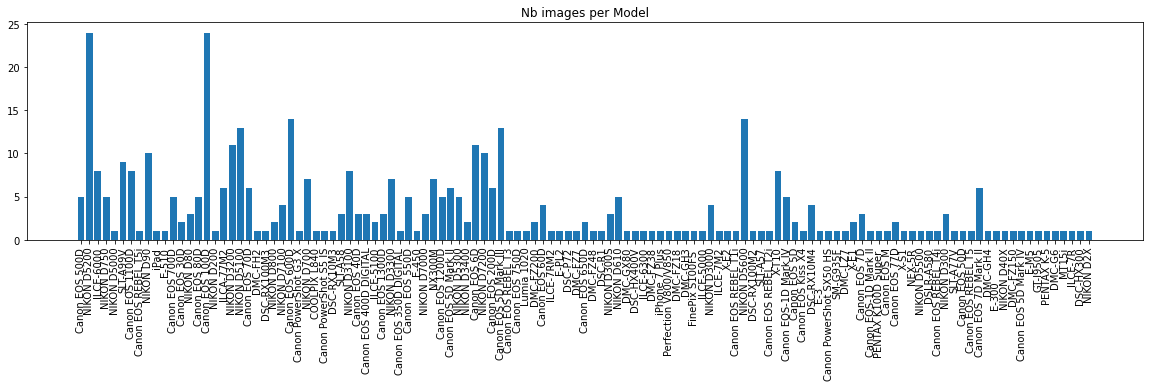

{'6000x4000': 11, '4000x6000': 4, '5210x3499': 1, '5944x3963': 1, '4901x3417': 1, '4751x3984': 1}


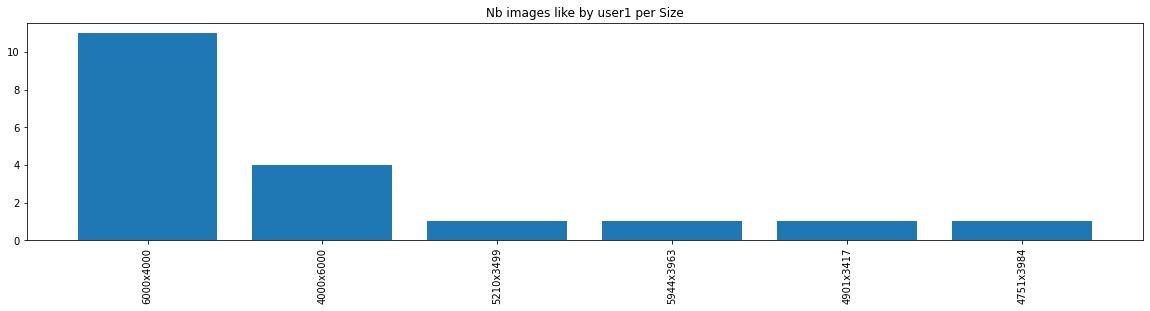

['#553622', '#735847', '#b4a1a7']
['darkolivegreen', 'dimgray', 'darkgray']
6000x4000


In [134]:
!pip install webcolors
import matplotlib.pyplot as plot
import json
import operator
import statistics
from scipy.spatial import KDTree
from webcolors import (
    CSS3_HEX_TO_NAMES,
    hex_to_rgb,
)

def convert_hex_to_names(hexColor):
    rgb_tuple = hex_to_rgb(hexColor)
    # a dictionary of all the hex and their respective names in css3
    css3_db = CSS3_HEX_TO_NAMES
    names = []
    rgb_values = []
    for color_hex, color_name in css3_db.items():
        names.append(color_name)
        rgb_values.append(hex_to_rgb(color_hex))
    
    kdt_db = KDTree(rgb_values)
    distance, index = kdt_db.query(rgb_tuple)
    return names[index]

def countByDate(metadata, user=None):
  date = dict()
  search=[]
  for i in range(2):
    with open('metadata/train/'+str(i)+'/metadata.json') as jsonFile :
      jsonObjects = json.load(jsonFile)
      jsonFile.close()
    if user is not None:
      liked = checkUserLike(user)
      chien = liked[0]
      chat = liked[1]
      if i == 0:
        search=chat
      else : 
        search=chien
    else :
      for j in range(len(jsonObjects)):
        search.append(j)
    for idx, jsonObject in enumerate(jsonObjects):
      if idx in search :
        if metadata in jsonObject:
          data = jsonObject[metadata]
          year = data.split(':')[0]
          if year in date:
            date[year]+=1
          else : 
            date[year]=1
  return date

def countByData(metadata, user=None):
  dataCount = dict()
  search=[]
  for i in range(2):
    with open('metadata/train/'+str(i)+'/metadata.json') as jsonFile :
      jsonObjects = json.load(jsonFile)
      jsonFile.close()
    if user is not None:
      liked = checkUserLike(user)
      chien = liked[0]
      chat = liked[1]
      if i == 0:
        search=chat
      else : 
        search=chien
    else :
      for j in range(len(jsonObjects)):
        search.append(j)
    for idx, jsonObject in enumerate(jsonObjects):
      if idx in search :
        if metadata in jsonObject:
          data = jsonObject[metadata]
          if data in dataCount:
            dataCount[data]+=1
          else : 
            dataCount[data]=1
  return dataCount

def countBySize(metadataWidth,metadataLength, user=None):
  dataCount = dict()
  search=[]
  for i in range(2):
    with open('metadata/train/'+str(i)+'/metadata.json') as jsonFile :
      jsonObjects = json.load(jsonFile)
      jsonFile.close()
    if user is not None:
      liked = checkUserLike(user)
      chien = liked[0]
      chat = liked[1]
      if i == 0:
        search=chat
      else : 
        search=chien
    else :
      for j in range(len(jsonObjects)):
        search.append(j)
    for idx, jsonObject in enumerate(jsonObjects):
      if idx in search :
        if metadataWidth in jsonObject:
          if metadataLength in jsonObject:
            data = str(jsonObject[metadataWidth])+'x'+str(jsonObject[metadataLength])
            if data in dataCount:
              dataCount[data]+=1
            else : 
              dataCount[data]=1
  return dataCount

def checkUserLike(user):
  chien = []
  chat = []
  if user is not None :
    with open('metadata/train/like_'+user+'.json') as jsonFile:
      jsonObjects = json.load(jsonFile)
      jsonFile.close()
    for jsonObject in jsonObjects :
      if jsonObject['tag']=='chien':
        if jsonObject['like']!=0:
          chien.append(jsonObject['id'])
      else:
        if jsonObject['like']!=0:
          chat.append(jsonObject['id'])
  return chien,chat

def rangeColor(user=None):
  colorRange = []
  colorRangeName = []
  search=[]
  listRed = []
  listGreen = []
  listBlue = []
  for i in range(2):
    with open('metadata/train/'+str(i)+'/tag.json') as jsonFile :
      jsonObjects = json.load(jsonFile)
      jsonFile.close()
    if user is not None:
      liked = checkUserLike(user)
      chien = liked[0]
      chat = liked[1]
      if i == 0:
        search=chat
      else : 
        search=chien
    else :
      for j in range(len(jsonObjects)):
        search.append(j)
    for idx, jsonObject in enumerate(jsonObjects):
      if idx in search :
        data = jsonObject['color']
        listRed.append(int(data[1:3], 16))
        listGreen.append(int(data[3:5], 16))
        listBlue.append(int(data[-2:], 16))
  colorRange.append('#'+hex(round(numpy.percentile(listRed, 25)))[-2:]+hex(round(numpy.percentile(listGreen, 25)))[-2:]+hex(round(numpy.percentile(listBlue, 25)))[-2:])
  colorRange.append('#'+hex(round(numpy.percentile(listRed, 50)))[-2:]+hex(round(numpy.percentile(listGreen, 50)))[-2:]+hex(round(numpy.percentile(listBlue, 50)))[-2:])
  colorRange.append('#'+hex(round(numpy.percentile(listRed, 75)))[-2:]+hex(round(numpy.percentile(listGreen, 75)))[-2:]+hex(round(numpy.percentile(listBlue, 75)))[-2:])
  colorRangeName.append(convert_hex_to_names(colorRange[0]))
  colorRangeName.append(convert_hex_to_names(colorRange[1]))
  colorRangeName.append(convert_hex_to_names(colorRange[2]))
  return colorRange, colorRangeName

def barGraph(countMetadata,titre): 
  data = countMetadata
  names = list(data.keys())
  values = list(data.values())
  plot.rcParams["figure.figsize"] = (20, 4)
  plot.bar(range(len(data)), values, tick_label=names)
  plot.xticks(rotation=90)
  plot.title(titre)
  plot.show()

print(countByDate('DateTimeOriginal'))
barGraph(countByDate('DateTimeOriginal'),"Nb images per Date")
print(countByData('Model'))
barGraph(countByData('Model'),"Nb images per Model")
print(countBySize('ImageWidth','ImageLength','user1'))
barGraph(countBySize('ImageWidth','ImageLength','user1'),"Nb images like by user1 per Size")
# Quartiles de la couleur principal sous format hexadécimal
print(rangeColor('user2')[0])
# Quartiles de la couleur principal sous format nom le plus proche
print(rangeColor('user2')[1])

#Taille la plus utilisées
print(max(countBySize('ImageWidth','ImageLength').items(), key=operator.itemgetter(1))[0])

##Système de recommandation

In [135]:
import pandas as pd
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#Matrice utilisateur
def getTop(liste,n=3):
  maxi = []
  for i in range(n):
    if liste:
      maximum = max(liste.items(), key=operator.itemgetter(1))[0]
      maxi.append(maximum)
      del liste[maxi[i]]
    else :
      maxi.append(maximum)
  return maxi

date = getTop(countByDate('DateTimeOriginal','user1'))
size = getTop(countBySize('ImageWidth','ImageLength','user1'))
model = getTop(countByData('Model','user1'))
user1 = pd.DataFrame(
    {
        "Date": pd.Series(date),
        "Size": pd.Series(size),
        "Model": pd.Series(model),
    }
)
user1['Model'] = user1['Model'].apply(lambda x: [i.replace(' ','') for i in x])

chien = pd.read_json('metadata/train/1/metadata.json')
chienTag = pd.read_json('metadata/train/1/tag.json')
chien = chien.merge(chienTag, on='id')
chat = pd.read_json('metadata/train/0/metadata.json')
chatTag = pd.read_json('metadata/train/0/tag.json')
chat = chat.merge(chatTag, on='id')
animals = pd.concat([chien, chat], ignore_index=True)
ids = []
for i in animals["id"]:
  ids.append(str(i))
animals['id'] = pd.Series(ids)
tags = []
for t in animals["tag"]:
  tags.append(str(t))
animals['tag'] = pd.Series(tags)
animals['id_tag']=animals.apply(lambda x : ''.join(x['id'])+'_'+''.join(x['tag']),axis = 1)
dates = []
for date in animals["DateTimeOriginal"]:
  if date == "nan":
    dates.append(date)
  else :
    dates.append(str(date).split(':')[0])
animals["Date"] = pd.Series(dates)
width=[]
for w in animals["ImageWidth"]:
  if str(w) == "nan":
    width.append(w)
  else :
    width.append(int(w))
length=[]
for l in animals["ImageLength"]:
  if str(l) == "nan":
    length.append(l)
  else :
    length.append(int(l))
size=[]
for adczzf in range(len(length)):
  size.append(str(width[adczzf])+"x"+str(length[adczzf]))
animals['Size'] = pd.Series(size)
verif = animals.copy()
model = []
for m in animals["Model"]:
  model.append(str(m))
animals['Model'] = pd.Series(model)
animals['Model'] = animals['Model'].apply(lambda x: [i.replace(' ','') for i in x])
animals['metadata']=animals.apply(lambda x : ''.join(x['Date'])+' '+''.join(x['Size'])+' '+''.join(x['Model']), axis = 1)
count_vec = CountVectorizer(stop_words='english')
count_vec_matrix = count_vec.fit_transform(animals['metadata'])
cosine_sim_matrix = cosine_similarity(count_vec_matrix, count_vec_matrix)
mapping = pd.Series(animals.index,index = animals['id_tag'])

def recommend_based_on_metadata(input):
  index = mapping[input]
  #get similarity values
  similarity_score = list(enumerate(cosine_sim_matrix[index]))
  similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
  # 5 first images
  similarity_score = similarity_score[1:5]
  indices = [i[0] for i in similarity_score]
  return (animals['id_tag'].iloc[indices])

#User1 likes
user = 'user1'
like = []
with open('metadata/train/like_'+user+'.json') as jsonFile:
  jsonObjects = json.load(jsonFile)
  jsonFile.close()
  for jsonObject in jsonObjects :
    if jsonObject['like']!=0:
      like.append(str(jsonObject['id'])+'_'+jsonObject['tag'])
reco = dict()
for l in like :
  for i in recommend_based_on_metadata(l):
    if i in reco:
      reco[i]+=1
    else : 
      reco[i]=1

# Images les 5 les plus similaire au images liké par l'utilisateur 1 
print(sorted(reco.items(),key=lambda t:t[1], reverse=True)[0:5])

[('8_chat', 11), ('9_chat', 11), ('46_chat', 8), ('37_chat', 7), ('99_chat', 6)]


##Test

In [136]:
print("Tailles préférées : "+str(sorted(countBySize('ImageWidth','ImageLength','user1'),key=lambda t:t[1])))
print("Dates préférées : "+str(sorted(countByDate('DateTimeOriginal','user1'),key=lambda t:t[1])))
print("Models préférés : "+str(sorted(countByData('Model','user1'),key=lambda t:t[1])))

#Liste de recommendation
print("====Entrainement====")
recommandation = getTop(reco,5)
print("Images recommandées :"+str(recommandation))

print("Images avec metadata :")
for v in range(len(verif)) :
  if verif['id_tag'][v] in recommandation :
    print("id_tag : "+verif['id_tag'][v]+", Date : "+str(verif['Date'][v])+", Size : "+str(verif['Size'][v])+", Model : "+str(verif['Model'][v]))

#Création dataset de test
chienTest = pd.read_json('metadata/test/1/metadata.json')
chienTagTest = pd.read_json('metadata/test/1/tag.json')
chienTest = chienTest.merge(chienTagTest, on='id')
chatTest = pd.read_json('metadata/test/0/metadata.json')
chatTagTest = pd.read_json('metadata/test/0/tag.json')
chatTest = chatTest.merge(chatTagTest, on='id')
animalsTest = pd.concat([chienTest, chatTest],ignore_index=True)
ids = []
for i in animalsTest["id"]:
  ids.append(str(i))
animalsTest['id'] = pd.Series(ids)
tags = []
for t in animalsTest["tag"]:
  tags.append(str(t))
animalsTest['tag'] = pd.Series(tags)
animalsTest['id_tag']=animalsTest.apply(lambda x : ''.join(x['id'])+'_'+''.join(x['tag']),axis = 1)
dates = []
for date in animalsTest["DateTimeOriginal"]:
  if date == "nan":
    dates.append(date)
  else :
    dates.append(str(date).split(':')[0])
animalsTest["Date"] = pd.Series(dates)
width=[]
for w in animalsTest["ImageWidth"]:
  if str(w) == "nan":
    width.append(w)
  else :
    width.append(int(w))
length=[]
for l in animalsTest["ImageLength"]:
  if str(l) == "nan":
    length.append(l)
  else :
    length.append(int(l))
size=[]
for adczzf in range(len(length)):
  size.append(str(width[adczzf])+"x"+str(length[adczzf]))
animalsTest['Size'] = pd.Series(size)
verif = animalsTest.copy()
model = []
for m in animalsTest["Model"]:
  model.append(str(m))
animalsTest['Model'] = pd.Series(model)
animalsTest['Model'] = animalsTest['Model'].apply(lambda x: [i.replace(' ','') for i in x])
animalsTest['metadata']=animalsTest.apply(lambda x : ''.join(x['Date'])+' '+''.join(x['Size'])+' '+''.join(x['Model']), axis = 1)
animalsTest = pd.concat([animals,animalsTest], ignore_index=True)
count_vecTest = CountVectorizer(stop_words='english')
count_vec_matrixTest = count_vec.fit_transform(animalsTest['metadata'])
cosine_sim_matrixTest = cosine_similarity(count_vec_matrixTest, count_vec_matrixTest)
mappingTest = pd.Series(animalsTest.index,index = animalsTest['id_tag'])

def recommend_based_on_metadataTest(input):
  index = mappingTest[input]
  #get similarity values
  similarity_score = list(enumerate(cosine_sim_matrixTest[index]))
  similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
  # 5 first images
  similarityTest = []
  for idx, sim in enumerate(similarity_score):
    if int(str(sim).split(',')[0].split('(')[1]) >= 250 :
      similarityTest.append(sim)
  similarityTest = similarityTest[1:5]
  indices = [i[0] for i in similarityTest]
  return (animalsTest['id_tag'].iloc[indices])

#User1 likes
user = 'user1'
like = []
with open('metadata/train/like_'+user+'.json') as jsonFile:
  jsonObjects = json.load(jsonFile)
  jsonFile.close()
  for jsonObject in jsonObjects :
    if jsonObject['like']!=0:
      like.append(str(jsonObject['id'])+'_'+jsonObject['tag'])
reco = dict()
for l in like :
  for i in recommend_based_on_metadataTest(l):
    if i in reco:
      reco[i]+=1
    else : 
      reco[i]=1

# Images les 5 les plus similaire au images liké par l'utilisateur 1 
print(sorted(reco.items(),key=lambda t:t[1], reverse=True)[0:5])

#Liste de recommendation
print("====Test====")
recommandation = getTop(reco,5)
print("Images recommandées :"+str(recommandation))

print("Images avec metadata :")
for v in range(len(verif)) :
  if verif['id_tag'][v] in recommandation :
    print("id_tag : "+verif['id_tag'][v]+", Date : "+str(verif['Date'][v])+", Size : "+str(verif['Size'][v])+", Model : "+str(verif['Model'][v]))


Tailles préférées : ['6000x4000', '4000x6000', '5210x3499', '4751x3984', '5944x3963', '4901x3417']
Dates préférées : ['2015', '2017', '2016', '2014']
Models préférés : ['NIKON D5200']
====Entrainement====
Images recommandées :['8_chat', '9_chat', '46_chat', '37_chat', '99_chat']
Images avec metadata :
id_tag : 8_chat, Date : 2015, Size : 6000x4000, Model : NIKON D5200
id_tag : 9_chat, Date : 2015, Size : 6000x4000, Model : NIKON D5200
id_tag : 37_chat, Date : 2015, Size : 6000x4000, Model : NIKON D5200
id_tag : 46_chat, Date : 2017, Size : 6000x4000, Model : NIKON D5200
id_tag : 99_chat, Date : 2015, Size : 6000x4000, Model : NIKON D5200
[('263_chat', 19), ('252_chat', 10), ('257_chat', 9), ('260_chat', 9), ('255_chat', 8)]
====Test====
Images recommandées :['263_chat', '252_chat', '257_chat', '260_chat', '255_chat']
Images avec metadata :
id_tag : 252_chat, Date : 2015, Size : 2592x1728, Model : Canon EOS 100D
id_tag : 255_chat, Date : 2017, Size : 4928x3264, Model : NIKON D5100
id_ta